<a href="https://colab.research.google.com/github/DrJaewookLee/math4ai-notes/blob/main/ex_part_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 연습 문제 2.5.

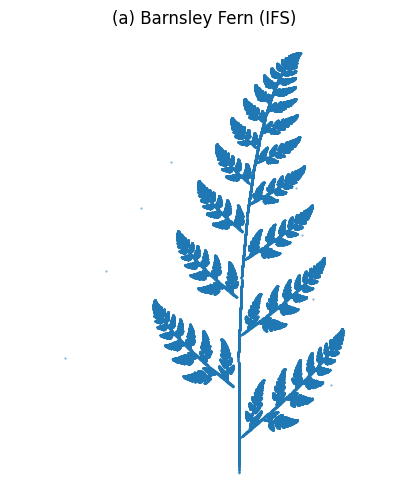

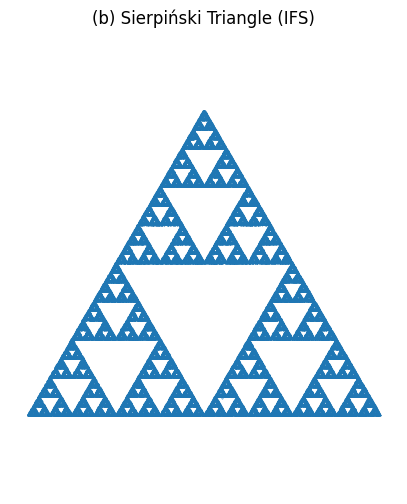

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_points(matrices_A, vectors_d, probs, z0=np.array([0.0, 0.0]), steps=200_000, seed=None):
    """
    Simulate z_{k+1} = A_{s_k} z_k + d_{s_k}, where s_k ~ probs.
    - matrices_A: list of 2x2 numpy arrays [A1, A2, ... , Am]
    - vectors_d: list of 2D numpy arrays [d1, d2, ... , dm]
    - probs: 1D numpy array of probabilities (sum to 1)
    - z0: initial 2D point
    - steps: number of iterations
    - seed: random seed for reproducibility
    Returns: (steps x 2) array of points [z_1, z_2, ..., z_steps]
    """
    rng = np.random.default_rng(seed)
    cdf = np.cumsum(probs)
    points = np.zeros((steps, 2), dtype=float)
    z = np.array(z0, dtype=float)

    for k in range(steps):
        r = rng.random()
        i = np.searchsorted(cdf, r)
        A = matrices_A[i]
        d = vectors_d[i]
        z = A @ z + d
        points[k] = z

    return points

def plot_points(points, title="IFS trajectory", save_path=None, show=True):
    """
    Plot a scatter of the points. One figure per plot, no explicit color settings.
    """
    plt.figure(figsize=(5, 6))
    plt.scatter(points[:, 0], points[:, 1], s=0.1)
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

# ----------------------
# (a) Barnsley Fern
# ----------------------
A1 = np.array([[ 0.0,   0.0  ],
               [ 0.0,   0.27 ]])
A2 = np.array([[-0.139, 0.263],
               [ 0.246, 0.224]])
A3 = np.array([[ 0.17, -0.215],
               [ 0.222, 0.176]])
A4 = np.array([[ 0.781, 0.034],
               [-0.032, 0.739]])

d1 = np.array([0.5,    0.0   ])
d2 = np.array([0.57,  -0.036 ])
d3 = np.array([0.408,  0.0893])
d4 = np.array([0.1075, 0.27  ])

probs_a = np.array([0.02, 0.15, 0.13, 0.70])

matrices_A_a = [A1, A2, A3, A4]
vectors_d_a  = [d1, d2, d3, d4]

points_a = simulate_points(matrices_A_a, vectors_d_a, probs_a, z0=np.array([0.0, 0.0]), steps=200_000, seed=42)
plot_points(points_a, title="(a) Barnsley Fern (IFS)")

# ----------------------
# (b) Example dataset: Sierpiński triangle (m = 3)
# ----------------------
# Affine maps: scale by 0.5 towards triangle vertices
B1 = 0.5 * np.eye(2)
B2 = 0.5 * np.eye(2)
B3 = 0.5 * np.eye(2)

# Triangle vertices
v1 = np.array([0.0, 0.0])
v2 = np.array([1.0, 0.0])
v3 = np.array([0.5, np.sqrt(3) / 2])

# Translations are half the vertex vectors (classic IFS choice)
e1 = v1 / 2
e2 = v2 / 2
e3 = v3 / 2

probs_b = np.array([1/3, 1/3, 1/3])

matrices_A_b = [B1, B2, B3]
vectors_d_b  = [e1, e2, e3]

points_b = simulate_points(matrices_A_b, vectors_d_b, probs_b, z0=np.array([0.1, 0.1]), steps=100_000, seed=7)
plot_points(points_b, title="(b) Sierpiński Triangle (IFS)")


### 연습 문제 3.5.

(a) saved plot to: qr_semilogy.png
Part (b) orthogonality residuals:
  ||Q^T Q - I|| (Householder) = 1.111052298468932e-16
  ||Qm^T Qm - I|| (MGS)       = 3.254726094493924e-11


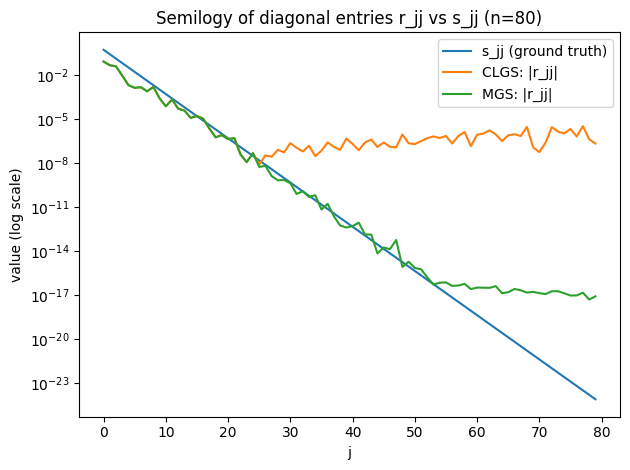

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


# ------------------------------
# 1) QR 구현: CLGS / MGS / Householder + formQ
# ------------------------------
def clgs(A: np.ndarray):
    """Classical Gram–Schmidt: A (m×n) -> Q (m×n), R (n×n)."""
    A = np.array(A, dtype=float)
    m, n = A.shape
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    for j in range(n):
        v = A[:, j].copy()
        for i in range(j):
            R[i, j] = Q[:, i] @ A[:, j]
            v -= R[i, j] * Q[:, i]
        R[j, j] = la.norm(v)
        Q[:, j] = v / R[j, j] if R[j, j] != 0 else v
    return Q, R


def mgs(A: np.ndarray):
    """Modified Gram–Schmidt: A (m×n) -> Q (m×n), R (n×n)."""
    A = np.array(A, dtype=float)
    m, n = A.shape
    V = A.copy()
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    for j in range(n):
        v = V[:, j]
        R[j, j] = la.norm(v)
        Q[:, j] = v / R[j, j] if R[j, j] != 0 else v
        for k in range(j + 1, n):
            R[j, k] = Q[:, j] @ V[:, k]
            V[:, k] -= R[j, k] * Q[:, j]
    return Q, R


def qrhouse(A: np.ndarray):
    """Householder QR: return Householder vectors V (m×n) and R (n×n, upper-triangular)."""
    A = np.array(A, dtype=float)
    m, n = A.shape
    R = A.copy()
    V = np.zeros((m, n), dtype=float)
    for j in range(min(m, n)):
        x = R[j:, j].copy()
        normx = la.norm(x)
        if normx == 0:
            v = x
        else:
            alpha = -np.copysign(normx, x[0])  # avoid cancellation
            v = x.copy()
            v[0] -= alpha
            vnorm = la.norm(v)
            v = v / vnorm if vnorm != 0 else v
        V[j:, j] = v
        if la.norm(v) != 0:
            R[j:, j:] -= 2.0 * np.outer(v, v @ R[j:, j:])
    # zero out strict subdiagonal for neatness
    for i in range(1, m):
        for k in range(min(i, n)):
            R[i, k] = 0.0
    return V, R[:n, :]


def formQ(V: np.ndarray):
    """Reconstruct Q from Householder vectors V (m×n)."""
    m, n = V.shape
    Q = np.eye(m)
    for j in reversed(range(min(m, n))):
        v = V[j:, j]
        if la.norm(v) != 0:
            Q[j:, :] -= 2.0 * np.outer(v, v @ Q[j:, :])
    return Q


# ------------------------------
# 2) (a) 실험: A = U S V, semilogy 플롯
# ------------------------------
def experiment_a(n: int = 80, seed: int = 7, save_path: str = "qr_semilogy.png"):
    np.random.seed(seed)
    U, _ = la.qr(np.random.randn(n, n))
    V, _ = la.qr(np.random.randn(n, n))
    J = np.arange(1, n + 1, dtype=float)
    S = np.diag(2.0 ** (-J))
    A = U @ S @ V

    Qc, Rc = clgs(A)
    Qm, Rm = mgs(A)

    sjj = np.diag(S)
    rcjj = np.abs(np.diag(Rc))
    rmjj = np.abs(np.diag(Rm))

    plt.figure()
    plt.semilogy(sjj, label="s_jj (ground truth)")
    plt.semilogy(rcjj, label="CLGS: |r_jj|")
    plt.semilogy(rmjj, label="MGS: |r_jj|")
    plt.title("Semilogy of diagonal entries r_jj vs s_jj (n={})".format(n))
    plt.xlabel("j")
    plt.ylabel("value (log scale)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"(a) saved plot to: {save_path}")


# ------------------------------
# 3) (b) 실험: 거의 선형종속 2×2, 직교성 잔차 비교
# ------------------------------
def experiment_b():
    A2 = np.array([[0.70000, 0.70711],
                   [0.70001, 0.70711]], dtype=float)
    Qm2, Rm2 = mgs(A2)
    V2, R2 = qrhouse(A2)
    Q2 = formQ(V2)

    orth_hh = la.norm(Q2.T @ Q2 - np.eye(2))
    orth_mgs = la.norm(Qm2.T @ Qm2 - np.eye(2))

    print("Part (b) orthogonality residuals:")
    print("  ||Q^T Q - I|| (Householder) =", orth_hh)
    print("  ||Qm^T Qm - I|| (MGS)       =", orth_mgs)


# ------------------------------
# 4) 실행
# ------------------------------
if __name__ == "__main__":
    experiment_a()
    experiment_b()


### 연습 문제 3.6.

In [2]:
import numpy as np
import numpy.linalg as la

def givens_qr(A: np.ndarray):
    """
    Givens 회전으로 축소 QR 분해 수행.
    입력:  A (m x n), m >= n
    출력:  Q (m x n, 열 직교), R (n x n, 상삼각, diag >= 0)
    """
    A = np.array(A, dtype=float)
    m, n = A.shape
    if m < n:
        raise ValueError("givens_qr: m >= n 이어야 합니다.")

    # 전체 R, 전체 Q (Q는 m x m으로 누적)
    R_full = A.copy()
    Q_full = np.eye(m)

    # 각 열 j에 대해, 아래쪽 원소들을 Givens로 0으로 만듦
    for j in range(n):
        for i in range(m - 1, j, -1):
            a = R_full[i - 1, j]
            b = R_full[i, j]
            if abs(b) < 1e-15:     # 이미 0이라고 보면 건너뜀
                continue

            r = np.hypot(a, b)     # sqrt(a^2 + b^2) 안정계산
            c = a / r
            s = b / r

            # 왼쪽에서 Givens G = [[c, s], [-s, c]] 적용: R <- G R
            # 행 i-1, i 블록만 갱신
            row_i1 = R_full[i - 1, :].copy()
            row_i  = R_full[i, :].copy()
            R_full[i - 1, :] = c * row_i1 + s * row_i
            R_full[i,     :] = -s * row_i1 + c * row_i

            # Q <- Q G^T  (열 i-1, i 블록 갱신)
            # G^T = [[c, -s], [s, c]]
            col_i1 = Q_full[:, i - 1].copy()
            col_i  = Q_full[:, i].copy()
            Q_full[:, i - 1] = c * col_i1 - s * col_i
            Q_full[:, i]     = s * col_i1 + c * col_i

    # 축소형 추출
    R = R_full[:n, :]
    Q = Q_full[:, :n]

    # 대각을 양수로 정규화(부호 통일)
    for k in range(n):
        if R[k, k] < 0:
            R[k, :] *= -1.0
            Q[:, k] *= -1.0

    return Q, R


In [3]:
# 임의 행렬 예시
A = np.array([[2.,  1.,  0., -1.],
              [1.,  3.,  2.,  0.],
              [0., -1.,  1.,  4.],
              [2.,  0., -2.,  1.],
              [1.,  1.,  1.,  1.]])

# Givens-QR 수행
Q, R = givens_qr(A)

# (1) 재구성 오차
rec_err = la.norm(A - Q @ R, ord='fro')

# (2) 직교성 검사
orth_err = la.norm(Q.T @ Q - np.eye(Q.shape[1]), ord='fro')

print("||A - Q R||_F =", rec_err)
print("||Q^T Q - I||_F =", orth_err)

# (선택) NumPy QR과 비교 (부호까지 맞춰 비교)
Q_np, R_np = la.qr(A, mode='reduced')

# 두 R의 대각 부호를 일치시킴
sign = np.sign(np.diag(R_np))
sign[sign == 0] = 1.0
S = np.diag(sign)
R_align = S @ R
Q_align = Q @ S

print("||R_np - R_align||_F =", la.norm(R_np - R_align, ord='fro'))
print("||Q_np - Q_align||_F =", la.norm(Q_np - Q_align, ord='fro'))


||A - Q R||_F = 8.041666386290734
||Q^T Q - I||_F = 3.904009891611765e-16
||R_np - R_align||_F = 1.9600843476621296e-15
||Q_np - Q_align||_F = 2.3786569021211648


### 연습 문제 4.1.

In [5]:
import numpy as np
import numpy.linalg as la


def dft_loop(x):
    """
    O(n^2) Discrete Fourier Transform (loop version).
    Input: 1D array-like (real or complex)
    Output: 1D complex numpy array of the same length
    """
    x = np.asarray(x, dtype=complex)
    n = x.size
    X = np.zeros(n, dtype=complex)
    for k in range(n):
        acc = 0.0 + 0.0j
        for m in range(n):
            acc += x[m] * np.exp(-2j * np.pi * k * m / n)
        X[k] = acc
    return X


def dft_broadcast(x):
    """
    O(n^2) Discrete Fourier Transform (broadcast/matrix version).
    """
    x = np.asarray(x, dtype=complex)
    n = x.size
    k = np.arange(n).reshape(-1, 1)  # (n,1)
    m = np.arange(n).reshape(1, -1)  # (1,n)
    W = np.exp(-2j * np.pi * k * m / n)  # (n,n)
    return W @ x  # (n,)


def max_abs_diff(a, b):
    """Helper: maximum absolute difference between two arrays."""
    return np.max(np.abs(np.asarray(a) - np.asarray(b)))


if __name__ == "__main__":
    # -------- Test 1: random complex signal --------
    rng = np.random.default_rng(7)
    n = 32
    x1 = rng.standard_normal(n) + 1j * rng.standard_normal(n)

    X1_loop = dft_loop(x1)
    X1_brdc = dft_broadcast(x1)
    X1_np = np.fft.fft(x1)

    print("Random complex signal (n=32)")
    print("  max|DFT_loop - np.fft.fft|      =", max_abs_diff(X1_loop, X1_np))
    print("  max|DFT_broadcast - np.fft.fft| =", max_abs_diff(X1_brdc, X1_np))

    # -------- Test 2: sinusoid + sinusoid --------
    t = np.arange(n)
    f0, f1 = 3, 7
    x2 = np.cos(2 * np.pi * f0 * t / n) + 0.5 * np.sin(2 * np.pi * f1 * t / n)

    X2_loop = dft_loop(x2)
    X2_np = np.fft.fft(x2)

    print("\nSinusoid test (cos + 0.5*sin)")
    print("  max|DFT_loop - np.fft.fft|      =", max_abs_diff(X2_loop, X2_np))
    peak_idx = np.argmax(np.abs(X2_np))
    print("  dominant frequency index (np.fft) =", int(peak_idx))

    # Optional sanity checks (tolerances may be adjusted if needed)
    assert max_abs_diff(X1_loop, X1_np) < 1e-10
    assert max_abs_diff(X1_brdc, X1_np) < 1e-10
    assert max_abs_diff(X2_loop, X2_np) < 1e-10

    print("\nAll checks passed.")


Random complex signal (n=32)
  max|DFT_loop - np.fft.fft|      = 9.039042875548452e-14
  max|DFT_broadcast - np.fft.fft| = 9.12200747834463e-14

Sinusoid test (cos + 0.5*sin)
  max|DFT_loop - np.fft.fft|      = 5.235567411840115e-14
  dominant frequency index (np.fft) = 3

All checks passed.


### 연습 문제 4.2.

In [6]:
import numpy as np

def next_pow2(n: int) -> int:
    """Return the next power of two >= n."""
    return 1 << (n - 1).bit_length()

def fft_recur(x):
    """
    Radix-2 recursive FFT.
    Requires len(x) to be a power of two.
    Returns a complex numpy array of same length.
    """
    x = np.asarray(x, dtype=complex)
    n = x.size
    if n == 1:
        return x.copy()
    if n % 2 != 0:
        raise ValueError("fft_recur: length must be a power of two (radix-2).")
    # FFT of even and odd indices
    X_even = fft_recur(x[::2])
    X_odd  = fft_recur(x[1::2])
    m = n // 2
    twiddle = np.exp(-2j * np.pi * np.arange(m) / n)  # W_n^k
    z = twiddle * X_odd
    return np.concatenate([X_even + z, X_even - z])

def fft_with_padding(x):
    """
    FFT with zero-padding to the next power of two (for convenience).
    Returns (X, padded_x) so you know what was transformed.
    """
    x = np.asarray(x, dtype=complex)
    n = x.size
    m = next_pow2(n)
    if m != n:
        x_pad = np.zeros(m, dtype=complex)
        x_pad[:n] = x
    else:
        x_pad = x
    X = fft_recur(x_pad)
    return X, x_pad

# ------------------ Tests & Reporting ------------------

if __name__ == "__main__":
    rng = np.random.default_rng(42)

    # Test 1: length is a power of two (exact compare without padding)
    n1 = 64
    x1 = rng.standard_normal(n1) + 1j * rng.standard_normal(n1)
    X1_my = fft_recur(x1)
    X1_np = np.fft.fft(x1)
    err1 = np.max(np.abs(X1_my - X1_np))
    print(f"[Power-of-two] n={n1}, max|myFFT - npFFT| = {err1:.3e}")

    # Test 2: length is NOT a power of two (use zero-padding)
    n2 = 100
    x2 = rng.standard_normal(n2) + 1j * rng.standard_normal(n2)
    X2_my, x2_pad = fft_with_padding(x2)
    X2_np = np.fft.fft(x2_pad)  # compare on the padded vector
    err2 = np.max(np.abs(X2_my - X2_np))
    print(f"[Zero-padding] n={n2} -> padded to {x2_pad.size}, "
          f"max|myFFT - npFFT(padded)| = {err2:.3e}")

    # Test 3: sinusoid signal to see a clear spectral peak
    n3 = 128
    t = np.arange(n3)
    f0 = 7
    x3 = np.cos(2 * np.pi * f0 * t / n3)  # real sinusoid
    X3_my = fft_recur(x3)
    X3_np = np.fft.fft(x3)
    err3 = np.max(np.abs(X3_my - X3_np))
    peak_idx = int(np.argmax(np.abs(X3_np)))
    print(f"[Sinusoid] n={n3}, peak index (npFFT) = {peak_idx}, "
          f"max|myFFT - npFFT| = {err3:.3e}")


[Power-of-two] n=64, max|myFFT - npFFT| = 7.536e-15
[Zero-padding] n=100 -> padded to 128, max|myFFT - npFFT(padded)| = 1.589e-14
[Sinusoid] n=128, peak index (npFFT) = 7, max|myFFT - npFFT| = 1.838e-14
